<a href="https://colab.research.google.com/github/Laya-Anil/AIDI1002_Final_Project_GroupX_Laya_Prasanna/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%cd drive/MyDrive/content
!git clone https://github.com/fanolabs/out-of-scope-intent-detection.git


/content/drive/MyDrive/content
Cloning into 'out-of-scope-intent-detection'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 14 (delta 1), reused 14 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 608.67 KiB | 2.39 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [8]:
%cd /content/drive/MyDrive/content/out-of-scope-intent-detection

/content/drive/MyDrive/content/out-of-scope-intent-detection


In [7]:
!unzip oos_dataset.zip -d dataset
!unzip squad.zip -d dataset/


Archive:  oos_dataset.zip
  inflating: dataset/oos/train.tsv   
  inflating: dataset/oos/dev.tsv     
  inflating: dataset/oos/test.tsv    
Archive:  squad.zip
  inflating: dataset/squad/squad.tsv  


In [10]:
!pip install tensorboard_logger


In [11]:
!pip install -U pytorch-lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.5/849.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 63.7 MB/s eta 0:00:00


In [13]:
!python main.py \
  --data_dir "/content/drive/MyDrive/content/dataset" \
  --loss_ce_only \
  --num_train_epochs 1 \
  --train_batch_size 16 \
  --eval_batch_size 64 \
  --print_freq 1


2025-12-10 20:54:36.860824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765400076.891123    7613 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765400076.900955    7613 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765400076.925614    7613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765400076.925648    7613 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765400076.925656    7613 computation_placer.cc:177] computation placer alr

In [14]:
%cd /content/drive/MyDrive/content/out-of-scope-intent-detection
!python main.py \
  --data_dir "/content/drive/MyDrive/content/dataset" \
  --loss_ce_only \
  --num_train_epochs 1 \
  --train_batch_size 16 \
  --eval_batch_size 64 \
  --print_freq 1


/content/drive/MyDrive/content/out-of-scope-intent-detection
2025-12-10 21:16:21.223961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765401381.297796   13089 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765401381.321952   13089 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765401381.361628   13089 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765401381.361683   13089 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765401381.361

In [20]:
import torch
from models.Encoder import *
import configs
import dataloader as dllarge
from types import SimpleNamespace

opt = SimpleNamespace(
    data_dir="/content/drive/MyDrive/content/dataset",
    dataset_pos="oos",
    dataset_neg="squad",
    model="bert",
    loss_ce_only=True,
    known_cls_ratio=1.0,
    labeled_ratio=1.0,
    lr=2e-5,
    train_batch_size=16,
    eval_batch_size=64,
    n_oos=64,              # REQUIRED
    num_convex=23,         # REQUIRED
    num_convex_val=23,     # REQUIRED
    num_train_epochs=1,
    max_seq_length=30,
    feat_dim=768,
    temp=0.2,
    seed=888,
)

import dataloader as dllarge
dataset = dllarge.Data(opt)

opt.oos_label_id = len(dataset.label_list) - 1
opt.n_way = len(dataset.label_list)        # number of classes
opt.in_dim = opt.feat_dim

from models.Encoder import Encoder
model = Encoder(opt).cuda()
state_dict = torch.load("bert_ce_epoch1.pth")
model.load_state_dict(state_dict)
model.eval()

print("Model loaded successfully!")



Model loaded successfully!


In [28]:
train_embeddings = []
train_labels = []

model.eval()

with torch.no_grad():
    for batch in dataset.train_dataloader:
        input_ids = batch[0].cuda()
        input_mask = batch[1].cuda()
        labels = batch[3].cuda()

        # Use raw encoder WITHOUT named args
        hidden_states = model.mapping(input_ids, input_mask)

        # hidden_states shape: [batch_size, seq_len, hidden_dim]
        # -> CLS token is index 0
        cls_emb = hidden_states

        train_embeddings.append(cls_emb.cpu().numpy())
        train_labels.append(labels.cpu().numpy())

train_embeddings = np.concatenate(train_embeddings, axis=0)
train_labels = np.concatenate(train_labels, axis=0)

print("Train embeddings shape:", train_embeddings.shape)
print("Train labels shape:", train_labels.shape)


Train embeddings shape: (14992, 768)
Train labels shape: (14992,)


In [29]:
test_embeddings = []
test_labels = []

model.eval()
with torch.no_grad():
    for batch in dataset.test_dataloader:
        input_ids = batch[0].cuda()
        input_mask = batch[1].cuda()
        labels = batch[3].cuda()

        hidden_states = model.mapping(input_ids, input_mask)
        cls_emb = hidden_states

        test_embeddings.append(cls_emb.cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_embeddings = np.concatenate(test_embeddings, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

print("Test embeddings:", test_embeddings.shape)
print("Test labels:", test_labels.shape)


Test embeddings: (5700, 768)
Test labels: (5700,)


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train classifier
clf = LogisticRegression(
    max_iter=5000,
    n_jobs=-1,
    verbose=1
)
clf.fit(train_embeddings, train_labels)

# Predict
test_pred = clf.predict(test_embeddings)

# Accuracy
acc = accuracy_score(test_labels, test_pred)
print("Logistic Regression Accuracy:", acc)

print("\nCLASSIFICATION REPORT:\n")
print(classification_report(test_labels, test_pred))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Logistic Regression Accuracy: 0.7035087719298245

CLASSIFICATION REPORT:

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        30
           1       0.76      0.97      0.85        30
           2       0.78      0.97      0.87        30
           3       0.84      0.90      0.87        30
           4       0.86      0.83      0.85        30
           5       0.63      0.63      0.63        30
           6       0.85      0.93      0.89        30
           7       0.72      0.77      0.74        30
           8       0.86      1.00      0.92        30
           9       0.89      0.80      0.84        30
          10       0.91      0.97      0.94        30
          11       0.83      0.83      0.83        30
          12       0.88      1.00      0.94        30
          13       0.46      0.83      0.60        30
          14       0.69      0.90      0.78        30
          15       0.86      0.80      0.83        30
       

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


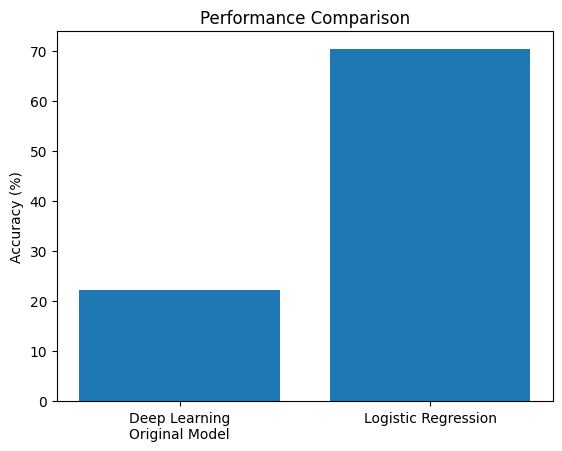

In [31]:
import matplotlib.pyplot as plt

plt.bar(["Deep Learning\nOriginal Model", "Logistic Regression"], [22.175, 70.35087719298245])
plt.ylabel("Accuracy (%)")
plt.title("Performance Comparison")
plt.show()
